## Training WRGAN

In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
import warnings


# 1. WRGAN model
from wrgan import RecurrentWGAN
# 2. Data loading
from data_loading import real_data_loading
# 3. Utils
from utils import Parameters
from shared.component_logger import component_logger as logger

#Evaluating Synthetic Data
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

warnings.filterwarnings("ignore")

## Specify Hyperparameters

In [2]:
#set the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data loading
data_path = "data/"
dataset = "stock"
path_real_data = "data/" + dataset + "_data.csv"
#Evaluation of the model, by default can be set to false.
eval_model = False

#parameters

params = Parameters()
params.dataset = dataset
params.data_path = "data/" + params.dataset + "_data.csv"
params.model_save_path = "checkpoints/" + params.dataset
params.seq_len = 24
params.batch_size = 128
params.max_steps = 100
params.save_model = True
params.print_every = 10
params.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params.save_synth_data = False

## Preprocessing Data

In [3]:
#preprocessing the data.

"""
Method: real_data_loading()
---------------------------------------------------------------------------------------------------------------------
    - Loads the data from the path.
    - Scales the data using a min-max scaler.
    - Slices the data into windows of size seq_len.
    - Shuffles the data randomly, and returns it.
"""
ori_data, (minimum, maximum) = real_data_loading(path_real_data, params.seq_len)

params.input_size = ori_data[0].shape[1]
params.latent_dim = params.input_size # For the sake of simplicity, we assume the latent dimension is the same as the input dimension.
params.hidden_size = 24
params.num_layers = 3
params.disc_extra_steps = 1 # The number of times the discriminator is trained more than the generator.
params.gp_lambda = 3 # The lambda value for the gradient penalty.

logger.log("Preprocessing Complete!")
   
with open(data_path + params.dataset + '_real_data.npy', 'wb') as f:
    np.save(f, np.array(ori_data))

logger.log("Saved real data!")

2022-07-28 11:24:09.370593: INFO: recurrent_wgan: <cell line: 20>: Preprocessing Complete!
2022-07-28 11:24:09.386183: INFO: recurrent_wgan: <cell line: 25>: Saved real data!


## Running WRGAN

In [4]:
"""
Method: train()
---------------------------------------------------------------------------------------------------------------------
    - Trains the wrgan model, and saves model weights.
"""

wrgan = RecurrentWGAN(params)
wrgan.train(ori_data)  


2022-07-28 11:24:11.357738: INFO: recurrent_wgan: train: [Step 0; L(C): 2.3458170890808105; L(G): -0.08563145250082016; dist(W): 0.03159943222999573]
2022-07-28 11:24:14.335008: INFO: recurrent_wgan: train: [Step 10; L(C): -0.18937233090400696; L(G): 0.13575021922588348; dist(W): 0.2234572470188141]
2022-07-28 11:24:17.365278: INFO: recurrent_wgan: train: [Step 20; L(C): -0.17872484028339386; L(G): 0.08980762958526611; dist(W): 0.18933314085006714]
2022-07-28 11:24:20.445329: INFO: recurrent_wgan: train: [Step 30; L(C): -0.17184922099113464; L(G): 0.05906469747424126; dist(W): 0.18173041939735413]
2022-07-28 11:24:23.491633: INFO: recurrent_wgan: train: [Step 40; L(C): -0.15647460520267487; L(G): 0.0340346097946167; dist(W): 0.1664748191833496]
2022-07-28 11:24:26.562147: INFO: recurrent_wgan: train: [Step 50; L(C): -0.15309911966323853; L(G): 0.023748096078634262; dist(W): 0.16840220987796783]
2022-07-28 11:24:29.647785: INFO: recurrent_wgan: train: [Step 60; L(C): -0.0968891084194183

## Loading pretrained models from checkpoint paths

In [5]:
generator_path = "./checkpoints/stock_generator.pth"
wrgan.load_model("generator", generator_path)

## Generate Synthetic Data

In [6]:
sample_size = 3661
generated_data = wrgan.generate_synthetic_data(sample_size)

## Evaluating Synthetic Data

In [7]:
with open('data/stock_real_data.npy', 'rb') as f:
    ori_data = np.load(f)

logger.log(ori_data.shape)
logger.log(generated_data.shape)

2022-07-28 11:24:41.799828: INFO: recurrent_wgan: <cell line: 4>: (3661, 24, 6)
2022-07-28 11:24:41.814788: INFO: recurrent_wgan: <cell line: 5>: (3661, 24, 6)


## Evaluate Synthetic Data

### 1. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis for **Diversity**.

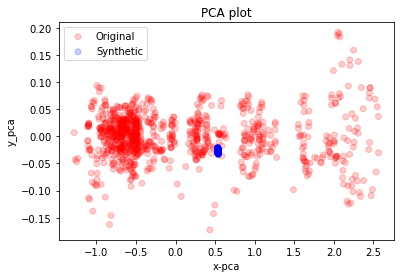

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.001351
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.752235
[t-SNE] KL divergence after 300 iterations: 0.993777


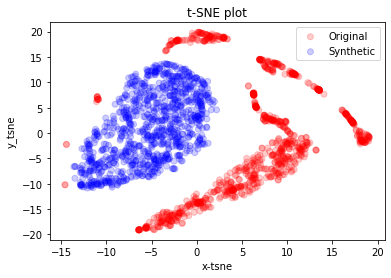

In [8]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')


### 2. Discriminative score
To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.



*   metric_iteration: the number of iterations for metric computation.




In [9]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
    temp_disc = discriminative_score_metrics(ori_data, generated_data)
    discriminative_score.append(temp_disc)

logger.log('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use tf.global_variables instead.
2022-07-28 11:37:06.254360: INFO: recurrent_wgan: <cell line: 8>: Discriminative score: 0.5


### 3. Predictive score
To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [10]:
predictive_score = list()
for tt in range(metric_iteration):
    temp_pred = predictive_score_metrics(ori_data, generated_data)
    predictive_score.append(temp_pred)   

logger.log('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

2022-07-28 11:53:30.357770: INFO: recurrent_wgan: <cell line: 6>: Predictive score: 0.3482
